### Parameter efficient fine-tuning with QLoRA

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

- PEFT : https://huggingface.co/docs/peft/index --> [PARAMETER EFFICIENT METHOD] This quicktour will show you PEFT’s main features and how you can train or run inference on large models that would typically be inaccessible on consumer devices.

-- prompt based methos : https://huggingface.co/docs/peft/task_guides/prompt_based_methods

-- Adapter based method : https://huggingface.co/docs/peft/conceptual_guides/adapter

-- peft config : https://huggingface.co/docs/peft/package_reference/config

-- QLoRA paper : https://arxiv.org/pdf/2305.14314



https://medium.com/@noufalsamsudin/microsoft-phi-2-for-classification-b83beaec2069 (phi-2 for classification)
https://mypy.readthedocs.io/en/stable/error_code_list.html (error code check in python )

https://docs.wandb.ai/quickstart/ (WINDB)

Fine-Tuning BERT for Classification: A Practical Guide: https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c

Fine tune BERT for text classification: https://medium.com/codex/fine-tune-bert-for-text-classification-cef7a1d6cdf1



- use encoder model -- BERT, RoBERT, DeBERTa, DistilBERT, ELECTRA
- For QLoRA , Encoder-Decoder, Encoder based LLMs work best if they support 4-bit quantization
- check competibility
    - if the model is pretrained for classification task
    - compatible with AutoModelForSequenceClassification
    - Easily adaptable for QLoRA/PEFT
      - make sure the model is compatible with BitsAndBytes 4-bit loading
      - use PEFT friendly setup (e.g - transformers, peft, accelerate versions aligned)
      - QLoRA compatible models: bert-base-uncased, roberta-base, mistral (decoder LLM - needs reformulation)

- ENCODER: direct classification
- DECODER: task reformulation, instruction + output generation and label must be parsed from text output.


  - IDEA:
      - start with bert-base-uncased, roberta-base, deberta-v3-small
      - if need LLM Scale: LLaMA-2, Mistral, Falcon [need reformunlate as prompt generation task]

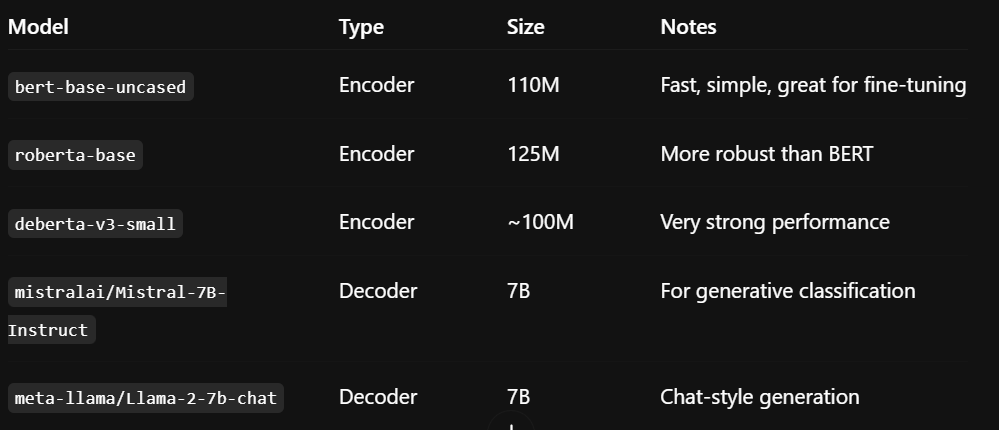

In [ ]:
 # transformers - provides pre-trained models and training utilities
# BitsAndBytesConfig - optimizers, matrix multiplication, quantization
# accelerate - boilerplate code relatted to multi GPus/TPU/fp16 and leave the rest of the code unchanged
# einops - simplify the tensore operation

In [ ]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score

In [ ]:
!pip install python-dotenv

# 1. Installed required libraries and setting up the notebook

In [ ]:
import pandas as pd
# transformers - provides pre-trained models and training utilities
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig, # optimizers, matrix multiplication, quantization
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig,
    DataCollatorForLanguageModeling,
    DataCollatorWithPadding,
    BertForSequenceClassification,
    BertTokenizer,
    BertConfig,
    DistilBertForSequenceClassification,
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import numpy as np
import os
from huggingface_hub import interpreter_login, notebook_login, login
from dotenv import load_dotenv
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

load_dotenv(dotenv_path = "/content/dirve/MyDrive/Thesis/env/.env")
api_key = os.getenv("HUG_FACE_API_KEY")
# print(api_key)

login(api_key)

In [ ]:
# os.listdir("/content/dirve/MyDrive/Thesis")

In [ ]:
# from dotenv import load_dotenv, find_dotenv
# load_dotenv()
# token = os.getenv('HUG_FACE_API_KEY')
# print(token)
# notebook_login(token)

In [ ]:
os.environ['WANDB_DISABLED'] = "true"

# 2. Loading the dataset and process

In [ ]:
# load the data - train, test, validation
train_df = pd.read_csv('/content/dirve/MyDrive/Thesis/data/train/data_llm_fine_tune.csv')
test_df = pd.read_csv('/content/dirve/MyDrive/Thesis/data/test/CT24_checkworthy_english_test_gold.tsv', delimiter = '\t') # WO l
dev_df = pd.read_csv('/content/dirve/MyDrive/Thesis/data/dev/second_dev_train.csv')

In [ ]:
dev_df.drop(['Unnamed: 0','Tokens',
       'text_length', 'cleaned_text', 'cleaned_text_length',
       'roberta_sentiment', 'roberta_sent_pos', 'roberta_sent_neg',
       'roberta_sent_mixed', 'roberta_sentiment_class', 'count_tokens',
       'counts', 'names', 'organizations', 'dates', 'punctuation_count',
       'embedding', 'converted_embedding', 'flattened_embedding', 'label',
       'joined_tokens', 'text-tfidf'], axis = 1, inplace = True)
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [ ]:
print(train_df.columns)
print(test_df.columns)
print(dev_df.columns)
print(test_df.value_counts('class_label'))
print(train_df.value_counts('class_label'))
print(dev_df.value_counts('class_label'))

In [ ]:
# convert the pd data into dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dev_dataset = Dataset.from_pandas(dev_df)

In [ ]:
# train_dataset

In [ ]:
# index = 0
# train_df.iloc[index]['Text']
# test_df.drop(['Unnamed: 0', 'Tokens', 'text_length',
#        'cleaned_text', 'cleaned_text_length', 'roberta_sentiment',
#        'roberta_sent_pos', 'roberta_sent_neg', 'roberta_sent_mixed',
#        'roberta_sentiment_class', 'count_tokens', 'counts', 'names',
#        'organizations', 'dates', 'punctuation_count', 'embedding',
#        'converted_embedding', 'flattened_embedding', 'joined_tokens',
#        'text-tfidf'], axis = 1, inplace = True)
# dev_df.drop(['Unnamed: 0','Tokens',
#        'text_length', 'cleaned_text', 'cleaned_text_length',
#        'roberta_sentiment', 'roberta_sent_pos', 'roberta_sent_neg',
#        'roberta_sent_mixed', 'roberta_sentiment_class', 'count_tokens',
#        'counts', 'names', 'organizations', 'dates', 'punctuation_count',
#        'embedding', 'converted_embedding', 'flattened_embedding', 'label',
#        'joined_tokens', 'text-tfidf'], axis = 1, inplace = True)
# train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

# 3. Create bitsandbytes configuration

### Bits And Bytes
bits and bytes enable accessable large language model via k-bit quantization. It provides three features.
- 8-bit optimizer (LoRA) use block wise quantization to maintain 32 bit performance at a small graction of memory cost.
- Without any performance degradation, 8 bit quantization  enables LLM model inference with only  half the required memory.
- QLoRA (4 bit quantization), more memory saving techniques without out compromising  performance.

In [ ]:
# bits and bytes configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # QLoRA - 4 bit quantization
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype = torch.bfloat16, # torch.brainfloat16 for better numerical stability
    bnb_4bit_quant_storage = torch.bfloat16,
)

# 4. Loading the pretrained model

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# model setup
model_name = 'microsoft/phi-2'
# model_name = 'bert-base-uncased'
device_map = {"":0}

# original_model = BertForSequenceClassification.from_pretrained(
#     model_name,
#     quantization_config = bnb_config,
#     device_map = device_map,
#     use_auth_token = True,
#     trust_remote_code = True
# )

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    use_auth_token = True,
    trust_remote_code = True
  )

# 5. Tokenization

In [ ]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code = True,
                                          padding_side = "left",
                                          add_eos_token = True, # no need for bert
                                          add_bos_token = True, # no need for bert
                                          use_fast = False, # for better performance
                                          # padding = True,
                                          # truncation = True,
                                          # return_tensor = 'pt'
                                          )
# tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# 6. Model with zero-shot inference

In [ ]:
# test the model with zero shot inferening
%%time
from transformers import set_seed, pipeline
seed = 42

set_seed(seed)

index = 3

prompt = test_df.iloc[index]['Text']
label = test_df.iloc[index]['class_label']

# print(prompt)
# print(label)

formated_prompt = f"Instruct: Is the following text is checkworthy for further verification or not. Answer should be in Yes or No. \n{prompt}\nOutput:\n"

# for bert ######################################
#gen = pipeline("text-classification", model = original_model, tokenizer = tokenizer)
# res = gen(formated_prompt)
# print(formated_prompt)
# print(res)
# print(label)
############################################# for phi-2
# gen = pipeline(model = original_model, tokenizer = tokenizer)
# res = gen(formated_prompt)
generated_text = original_model.generate(
    **tokenizer(formated_prompt,
        return_tensors = 'pt').to(original_model.device)
)
answer = tokenizer.decode(generated_text[0], skip_special_tokens = True)
print(answer)
print(label)
#########################################################################


print("Need Fine-Tuning")

# 7. pre process the text

## formating_prompt
- takes row from train and val dataset
- add the input text and class lebel in the formated prompt
- return the row

In [ ]:
def formating_prompt(sample):
  """
  Creating a new column with the text and instruction added for each row
  """
  INPUT_BLURB = "Below is an instruction that describe a text classification task. Write a response that appropriately completes the request."
  INSTRUCTION_KEY = "### Instruct: Is the following text is checkworthy for further verification or not. Give me answer in one word Yes or No."
  RESPONSE_KEY = "### Output:"
  END_KEY = "### End"

  blurb = f"\n{INPUT_BLURB}" # prompt will have intro text
  instruction = f"{INSTRUCTION_KEY}" # # the main instructions, main task to do
  input_context = f"{sample['Text']}" if sample["Text"] else None # checking if the column vakue of row contain any text, than add it
  response = f"{RESPONSE_KEY}\n{sample['class_label']}" # also add the original output  or classified label
  end = f"{END_KEY}" # ending point

  # make a list of all this parts
  parts = [part for part in [blurb, instruction, input_context, response, end] if part]

  # format as a text
  formatted_prompt = "\n\n".join(parts)

  # creare a seperate column for this prompt
  sample['prompt_text'] = formatted_prompt

  return sample


- process this prompts into tokenized ones
- inpit sequence with cinsistent length


In [ ]:
print(original_model.config)

In [ ]:
class length:
  #n_positions = 88
  max_position_embeddings = 200
  #seq_length = 1024
  x = 1

len = length()
name = None
for a in ["n_positions", "max_position_embeddings", "seq_length"]:
  name = getattr(len, a, None)
  if name:
    # print(name)
    break
if not name:
  name = 0
print(name)

In [ ]:
def get_length(model):
  """
  consistent sequence length:
  - benificial for fine tuning
  - minimizing the computational overhead
  - make sure dont surprass the max token limit
  """
  config = model.config
  max_length = None
  for len in ["n_positions", "max_position_embeddings", "seq_length"]:
    max_length = getattr(config, len, None)

    if max_length: # max_position_embeddings is there in the model config, which is 2048... should return this number
      print(f"Found the max length: {max_length}")
      break
  if not max_length:
      max_length = 1024 # set a new max length
      print(f"Setting new max length: {max_length}")
  return max_length

In [ ]:
def preprocess_batch(batch, tokenizer, max_length):
  """
  Tokenizing a batch
  """
  ## preprocessing by batch ##############
  # return tokenizer(
  #     batch['prompt_text'],
  #     padding = 'max_length',
  #     truncation = True,
  #     max_length = max_length,
  #     return_tensors = "pt"
  # )
  ##########################
  # preprocessing by text #####
  return tokenizer(
      batch["prompt_text"], # sequence or batch of sequence to be encoded
      max_length = max_length, # token max length specified in the original_model
      truncation = True # True - Truncate to a max length specified as max_length
  )
  #########################

- 1. epoch - one forward and backward pass of all the training examples. (more epoch ,improve weight further).

- 2. batch - total numnber of training example present in each batch.
- 3. iteration - are the number of batches needed to complete one epoch

training example : 1000, batch size : 500, epoch 1

to complete 1 epoch, we need 2 batch and need 2 iteration.

one forward and backward pass, need 2 batch to complete

In [ ]:
from functools import partial

In [ ]:
def preprocess_data(tokenizer: AutoTokenizer, max_length: int, seed, dataset):
  # nedd tokenizer as parameter to pass into the preprocess_bacth function
  # need max_length for consistency
  # seed for randomization
  # dataset - pass the full dataset

  print("Preprocessing data...")
  # dataset = dataset.apply(formating_prompt, axis = 1) # formating_prompt will take each row at a time from the dataset and add a new column with formatted prompt. --column name is prompt_text

  dataset = dataset.map(formating_prompt)

  # apply preprocessing to each batch
  _preprocessing = partial(preprocess_batch, max_length = max_length, tokenizer = tokenizer)

  # https://huggingface.co/docs/datasets/about_map_batch#map
  dataset = dataset.map(
      _preprocessing,
      #lambda examples:_preprocessing(examples),
      batched = True,
      remove_columns = ['Sentence_id', 'Text']
      )

  # dataset['processed_text'] = dataset['prompt_text'].apply(_preprocessing) ---
  # filter otut samples that have input_ids exciding max_length
  # dataset = dataset.filter(lambda x: len(x['input_ids']) < max_length)


  ### when using batch size with bert model #####
  # dataset['processed_text'] = dataset['prompt_text'].apply(
  #       lambda x: preprocess_batch({'prompt_text': [x]}, tokenizer, max_length)
  #   )
  ################################################

  # shuffel the dataset
  dataset = dataset.shuffle(seed = seed)

  return dataset





In [ ]:
# get the max_length of sequence
max_length = get_length(original_model)
print(max_length)

# preprocess train and dev data set

train_dataset_new = preprocess_data(tokenizer, max_length, seed, train_dataset)
eval_dataset_new = preprocess_data(tokenizer, max_length, seed, dev_dataset)

In [ ]:
print(train_dataset_new[0])

In [ ]:
print(train_dataset_new.features)
print(eval_dataset_new.features)

In [ ]:
def lebel_encode(sample):
  sample["class_label"] = 1.0 if sample["class_label"] == "Yes" else 0.0
  return sample

In [ ]:
train_dataset_new = train_dataset_new.map(lebel_encode)
eval_dataset_new = eval_dataset_new.map(lebel_encode)

In [ ]:
print(train_dataset_new.features)
print(eval_dataset_new.features)

In [ ]:
# train_dataset.loc[0, 'processed_text']['attention_mask']

In [ ]:
# seperat column for the input_ids and attention_mask
# train_dataset['input_ids'] = train_dataset['processed_text'].apply(lambda x: x['input_ids'])
# train_dataset['attention_mask'] = train_dataset['processed_text'].apply(lambda x: x['attention_mask'])
# train_dataset['token_type_ids'] = train_dataset['processed_text'].apply(lambda x: x['token_type_ids'])

# eval_dataset['input_ids'] = eval_dataset['processed_text'].apply(lambda x: x['input_ids'])
# eval_dataset['attention_mask'] = eval_dataset['processed_text'].apply(lambda x: x['attention_mask'])
# eval_dataset['token_type_ids'] =eval_dataset['processed_text'].apply(lambda x: x['token_type_ids'])

In [ ]:
# print(train_dataset['prompt_text'].iloc[5])
# print(train_dataset['input_ids'].iloc[5])
# print(train_dataset['token_type_ids'].iloc[5])
# print(train_dataset['attention_mask'].iloc[5])

# print(train_dataset['prompt_text'].iloc[-1])
# print(train_dataset['input_ids'].iloc[-1])
# print(train_dataset['token_type_ids'].iloc[-1])
# print(train_dataset['attention_mask'].iloc[-1])

In [ ]:
# print(train_dataset.columns)
# print(eval_dataset.columns)

In [ ]:
#len(list(train_dataset['input_ids'].iloc[0]))
# print(df)

In [ ]:
## drop all columns
#train_dataset.drop(['Sentence_id', 'Text', 'class_label'], axis = 1, inplace = True)
#eval_dataset.drop(['Sentence_id', 'Text', 'class_label'], axis = 1, inplace = True)

## shuffel
train_dataset = train_dataset.sample(frac = 1, random_state = seed) # frac = 1 , return all rows in random order
eval_dataset = eval_dataset.sample(frac = 1, random_state = seed)

In [ ]:
train_dataset.sample()

In [ ]:
eval_dataset.sample()

# 7. Preparing the model for QLoRA

In [ ]:
from peft import prepare_model_for_kbit_training,  LoraConfig, get_peft_model

In [ ]:
# call prepare_model_for_k_bit_training function to process the quantized model for training
original_model = prepare_model_for_kbit_training(original_model) # initialize the model for QLoRA

# 8. Set-up the PEFT for fine tuning

In [ ]:
# create a Loraconfig with the following parameter
# https://github.com/huggingface/peft/blob/v0.15.0/src/peft/tuners/lora/config.py#L200
# class LoraConfig(PeftConfig)
config = LoraConfig(
    r = 32,
    lora_alpha = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "dense"],
    bias = "none",
    lora_dropout=0.05,
    task_type = "CAUSAL_LM"

)

# checkpointing activation - use significantly less GPU
# https://huggingface.co/transformers/v4.11.3/performance.html?highlight=gradient_checkpointing
original_model.gradient_checkpointing_enable()


# create peftmodel from the quantized model and configuration
peft_model = get_peft_model(original_model, config)




In [ ]:
# https://huggingface.co/docs/peft/en/package_reference/peft_model
peft_model.print_trainable_parameters()

# 9. Train PEFT Adapter

In [ ]:
print(train_dataset.columns)
print(eval_dataset.columns)

In [ ]:
# dropping the extra columns
train_dataset = train_dataset.drop([ 'Sentence_id', 'Text', 'prompt_text', 'processed_text', 'token_type_ids'], axis = 1)
eval_dataset = eval_dataset.drop([ 'Sentence_id', 'Text', 'prompt_text', 'processed_text', 'token_type_ids'], axis = 1)

In [ ]:
# rename class_label inot label
train_dataset = train_dataset.rename(columns = {'class_label':'label'})
eval_dataset = eval_dataset.rename(columns = {'class_label':'label'})

In [ ]:
# convert lebel to int
train_dataset['label'] = train_dataset['label'].replace({"Yes": 1, "No": 0})
eval_dataset['label'] = eval_dataset['label'].replace({"Yes": 1, "No": 0})

In [ ]:
# Convert tensors to lists before passing them into the dataset --- when, was not working the next cell

## after this cell, the df converted to dataset no error showen ....
train_dataset['input_ids'] = train_dataset['input_ids'].apply(lambda x: x.tolist() if isinstance(x, torch.Tensor) else x)
train_dataset['attention_mask'] = train_dataset['attention_mask'].apply(lambda x: x.tolist() if isinstance(x, torch.Tensor) else x)

eval_dataset['input_ids'] = eval_dataset['input_ids'].apply(lambda x: x.tolist() if isinstance(x, torch.Tensor) else x)
eval_dataset['attention_mask'] = eval_dataset['attention_mask'].apply(lambda x: x.tolist() if isinstance(x, torch.Tensor) else x)

In [ ]:
# convert from panda to dataset, trainer need dataset format
train_data_converted = Dataset.from_pandas(train_dataset)
eval_data_converted = Dataset.from_pandas(eval_dataset)
# muted at the bert model time

In [ ]:
print(train_data_converted[0])

In [ ]:
## added during bert-- muted above cell
# ensure that the padding and truncating the input sequence to a fixed length during tokenization
# train_dataset['input_ids'] = train_dataset['input_ids'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=512, return_tensors='pt')['input_ids'].squeeze(0))
# train_dataset['attention_mask'] = train_dataset['attention_mask'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=512, return_tensors='pt')['attention_mask'].squeeze(0))


In [ ]:
# check is there any Nan Valu in label column
print(train_dataset['label'].isna().sum())
print(eval_dataset['label'].isna().sum())

In [ ]:
print(train_data_converted)
print(eval_data_converted)
print(train_data_converted.features)

In [ ]:
train_data_converted

In [ ]:
# removing extra columns from Dataset
column_to_keep = ['input_ids', 'attention_mask',
                  'label']
train_data_converted = train_data_converted.remove_columns([col for col in train_data_converted.column_names if col not in column_to_keep])
eval_data_converted = eval_data_converted.remove_columns([col for col in eval_data_converted.column_names if col not in column_to_keep])

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

In [ ]:
# peft_model.to('cuda') # force the model to use gpu

In [ ]:
# import torch
# import torch.nn as nn

# class PhiForBinaryClassification(nn.Module):
#     def __init__(self, base_model):
#         super().__init__()
#         self.base_model = base_model
#         self.lm_head = nn.Linear(base_model.config.hidden_size, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, input_ids=None, attention_mask=None, labels=None):
#         outputs = self.base_model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             output_hidden_states=True,  # required to get hidden states
#             return_dict=True
#         )

#         # use the last hidden state (from final decoder layer)
#         hidden_state = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_dim)
#         cls_output = hidden_state[:, 0, :]  # typically first token
#         logits = self.lm_head(cls_output).squeeze(-1)
#         probs = self.sigmoid(logits)

#         loss = None
#         if labels is not None:
#             labels = labels.float()
#             loss_fct = nn.BCELoss()
#             loss = loss_fct(probs, labels)

#         return {"loss": loss, "logits": probs}


In [ ]:
# print(tokenizer)

In [ ]:
output_dir = f'/content/gdrive/MyDrive/Thesis/fine-tuning/checkworthy-binary-classification-training-{str(int(time.time()))}'

# complete training and evaluation loop
# https://huggingface.co/docs/transformers/v4.51.1/en/trainer
# https://github.com/huggingface/transformers/blob/v4.51.1/src/transformers/training_args.py#L210
training_args = TrainingArguments(
    output_dir = output_dir,
    overwrite_output_dir = True,
    do_eval = True,
    eval_strategy = "steps",
    gradient_accumulation_steps = 4,
    max_steps = 1000,
    warmup_steps = 1,
    logging_steps = 25,
    save_strategy = "steps",
    save_steps = 25,
    eval_steps = 25,
    # for full set of optimizers: https://github.com/huggingface/transformers/blob/main/src/transformers/training_args.py
    optim = "paged_adamw_8bit",
    group_by_length = True,
    report_to = None,
    gradient_checkpointing = True,
    # group_by_length  = True,
    logging_dir = "./logs",
    learning_rate = 2e-5,
)

peft_model.config.use_cache = False
#peft_model.config.gradient_checkpointing = True


## wrappe the model
#wrapped_model = PhiForBinaryClassification(peft_model)

data_collator = DataCollatorWithPadding(tokenizer, return_tensors = "pt")

# https://huggingface.co/docs/transformers/v4.51.1/en/training
peft_trainer = Trainer(
    model = peft_model,
    args = training_args,
    train_dataset = train_dataset_new,
    eval_dataset = eval_dataset_new,
    # https://huggingface.co/docs/transformers/en/main_classes/data_collator
    data_collator =data_collator # return_tensor = pt, padding = True / longest [boll / str]
)


In [ ]:
# hugging face notebooks: https://huggingface.co/docs/transformers/v4.51.1/en/notebooks

In [ ]:
training_args.device

In [ ]:
# training the model
peft_trainer.train()

# 10. Evaluate the model quality